# Assignment 13: Forecast #13 & IPython Notebooks
**Name: Alcely Lau**

**Date: 11/23/2020**
___
#### Table of Contents:
1. [Introduction](#intro)
1. [Forecast summary](#forecast)
1. [Forecast evolution](#evol)
1. [Forecast location](#location)
1. [Forecast Code](#code)
1. [Results](#results)
1. [Graphs](#graphs)

___
<a name="intro"></a>
#### Introduction
This IPython notebook generates my streamflow forecast for week 1, week 2 and the 16 weeks seasonal forecast. Furthermore, it elaborates a map with the location of the forecast gauges and shows a discussion about the obtained results through graphs.

___
<a name="forecast"></a>
#### Forecast summary
For this week my forecast is a combination and improvement of many approaches that I had tried in the past. First, it calculates the historical daily mean flow for the period from 1989 to 2019 of the Station  09506000 Verde River Near Camp Verde. Next, the historical daily mean flow and the 2020 observed daily flow are averagered by weeks. Then, the inputs variables to my forecast are the historical weekly flow from august, 23 to the following 16 weeks and the 2020 observed weekly flow from august 23 to the most recent week. 

- For week 1 and week 2: the predicted flow are the historical weekly flow for it corresponding week multiplied by a factor.
- For the seasonal forecast: it applies a regression model with the input values as x and y. Also, an adjustment factor is applied.

___
<a name="evol"></a>
#### Forecast evolution
My forecast evolution has been a process with some steps forward and some steps backward. I started using only the mean of the year 2019. Then, for 1 week I tried luck using an autoregressive model with the weekly flow and 1 shift. Next, I went some steps back and used a similar process that the one that I'm using now for my week 1 and week 2. Hence, with the team forecast, I went some steps forward and used a autoregressive model with 8 or 9 shifts. And last week, I used a regression model including the flow with 8 shifts and the air temperature at 2 m above the surface. Now, I am returning back to basics.

___
<a name="location"></a>
#### Forecast location
As aforemention, the streamflow forecast is for the USGS Station 09506000 Verde River Near Camp Verde. 
The data is downloaded directly from USGS NWIS website to python, [mapper](https://maps.waterdata.usgs.gov/mapper/) using the following parameters:
  - Station  09506000 Verde River Near Camp Verde
  - Daily Data
  - Parameter 00060 Discharge (mean)
  - Start date = 1989-01-01
  - End date = Today
  - Select 'tab separated'
  
First, let import all the packages that are required for this notebook to work correctly. 


In [8]:
# Section 0: Import the modules we will use.
# Note: you may need to install some packages.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import help_function as hf
import seaborn as sns
import geopandas as gpd
import fiona
import contextily as ctx

The following code generates a map, which indicates, with a blue star, the location of the Station 09506000 Verde River Near Camp Verde.

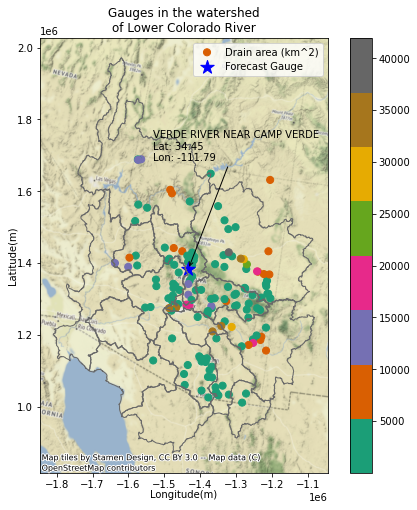

In [9]:
# Section 1: Create a Map
# Section 1.2: Looking the LAT and LON of specific USGS gauge
# Gauges II USGS stream gauge dataset:
# Download here:
# https://water.usgs.gov/GIS/metadata/usgswrd/XML/gagesII_Sept2011.xml#stdorder
file = r'..\..\data\gagesII_9322_point_shapefile\gagesII_9322_sept30_2011.shp'
gages = gpd.read_file(file)

# Section 1.3: Creating dataframe USGS stream gauge
df_usgs = pd.DataFrame({'STAID': ['09506000'],
                        'STANAME': ['VERDE RIVER NEAR CAMP VERDE, AZ'],
                        'LAT': [34.448361],
                        'LON': [-111.789871]})

# Section 1.4: Adding more datasets
# Watershed boundaries for the lower colorado:
# https://viewer.nationalmap.gov/basic/?basemap=b1&category=nhd&title=NHD%20View

file = r'..\..\data\WBD_15_HU2_GDB\WBD_15_HU2_GDB.gdb'
fiona.listlayers(file)
HUC6 = gpd.read_file(file, layer="WBDHU6")

# Section 1.5: Arizona USGS gauges
gages_AZ = gages[gages['STATE'] == 'AZ']

# Section 1.6: creating the GeoDataFrame
# USGS
gdf_usgs = gpd.GeoDataFrame(
    df_usgs, geometry=gpd.points_from_xy(df_usgs.LON, df_usgs.LAT),
    columns=['geometry'], crs=HUC6.crs)

# Change projection of HUC6
HUC6_az = HUC6.to_crs(gages_AZ.crs)
usgs_az = gdf_usgs.to_crs(gages_AZ.crs)

# Section 1.7: Map
fig, ax = plt.subplots(figsize=(8, 8))
gages_AZ.plot(column='DRAIN_SQKM', categorical=False,
              legend=True, markersize=50, cmap='Dark2',
              ax=ax, label='Drain area (km^2)')
usgs_az.plot(ax=ax, color='b', marker='*', markersize=200,
             label='Forecast Gauge')
HUC6_az.boundary.plot(ax=ax, color=None,
                      edgecolor='dimgrey', linewidth=1)
plt.ylabel('Latitude(m)', fontsize=10, labelpad=0)
plt.xlabel('Longitude(m)', fontsize=10, labelpad=0)
plt.title('Gauges in the watershed\nof Lower Colorado River')
text = ('VERDE RIVER NEAR CAMP VERDE' +
        '\nLat: 34.45\nLon: -111.79')
plt.annotate(text, xy=(-1432892.272, 1384411.251),
             xycoords='data', xytext=(-1532892, 1684411), textcoords='data',
             arrowprops=dict(arrowstyle="->"))
ctx.add_basemap(ax, crs=gages_AZ.crs)
ax.legend()

plt.savefig('lau_map.png')

___
<a name="code"></a>
#### Forecast code
The following code generates the streamflow forecast applying the approach mentioned in the `Forecast Summary`. This part of the code is using an auxilary Python script called `help_function.py`, which contains all my created functions. The outputs of this code will be printed in the `Results` section.

**Note**:
- Remeber to run first the `code section 0` to import the packages.
- To begin the forecast process, you must update the following variables (*already done*). 

In [10]:
# Section 2: Modify the following variables
current_week = 13

# USGS URL for the flow data:
site = '09506000'
start = '1989-01-01'
end = '2020-11-21'

The following code sections are for download the flow data and do the forecast estimations.

In [11]:
# Section 3: Download the flow data directly from the USGS website.


url = "https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=" + \
      site + "&referred_module=sw&period=&begin_date=" + start + \
      "&end_date=" + end
data = pd.read_table(url, skiprows=30,
                     names=['agency_cd', 'site_no',
                            'datetime', 'flow', 'code'],
                     parse_dates=['datetime'])

# Expand the dates to year, month, day, and days of the week.
data['year'] = pd.DatetimeIndex(data['datetime']).year
data['month'] = pd.DatetimeIndex(data['datetime']).month
data['day'] = pd.DatetimeIndex(data['datetime']).day
data['dayofweek'] = pd.DatetimeIndex(data['datetime']).dayofweek

# Aggregate flow values to weekly: from sunday to saturday
flow_weekly = data.resample("W-SAT", on='datetime').mean()


# Section 4: The forecast
# Step 4.1: Calculate the historical daily mean flow.

hist_flow = hf.hist_daily_mean(data, 2020)

# Step 4.2: create a dataframe to store all the variables
# related to the forecast.
# Step 4.3: aggregate the historical daily mean flow to weekly
# starting from 2020-08-23 to the following 15 weeks.
mymodel = pd.DataFrame(
    {'hist_data': hf.weekly_mean(hist_flow, 8, 29, 16),
     'data_2020': np.zeros(16)},
    index=np.arange(1, 17))

# Step 4.4: Store in the df the 2020 weekly flow
# from 2020-08-23 to the most recent value
mymodel['data_2020'] = (mymodel['data_2020'].iloc[0:current_week] +
                        flow_weekly['2020-08-29':]['flow'].values
                        ).round(2)

# Step 4.5: calculate correction factor
mymodel['factors'] = (mymodel.data_2020.values /
                      mymodel.hist_data.values
                      ).round(3)

# Step 4.6: Brain model for 16 weeks
mymodel['forecasts16'] = (mymodel['hist_data'].values *
                          mymodel['factors'][11:current_week].mean()
                          ).round(2)

# Step 4.7: Regressive model for 16 weeks
x = mymodel.iloc[7:current_week][['hist_data']].values.reshape(-1, 1)
y = mymodel.iloc[7:current_week]['data_2020'].values

lt_pred = []
for i in range(16):
    initial_xval = mymodel['hist_data'].iloc[i]
    if i < 4:
        pred = (hf.R_Model(x, y, initial_xval) * 0.6).round(2)
    else:
        pred = hf.R_Model(x, y, initial_xval).round(2)
    lt_pred.append(pred[0])

mymodel['Rmodel'] = lt_pred

print(' \n go to Result section')

# Just to check 
mymodel

Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
Coefficient of Determination =  0.83
 
 go to Result section


,hist_data,data_2020,factors,forecasts16,Rmodel
1,161.527,53.64,0.332,102.97,48.09
2,197.060,57.69,0.293,125.63,67.14
3,158.102,43.23,0.273,100.79,46.25
4,198.930,58.00,0.292,126.82,68.14
5,129.252,60.89,0.471,82.40,51.30
6,145.559,60.29,0.414,92.79,65.87
7,128.697,65.70,0.511,82.04,50.81
8,152.730,73.66,0.482,97.37,72.28
9,186.063,80.16,0.431,118.62,102.07
10,197.733,108.97,0.551,126.05,112.50


___
<a name="results"></a>
#### Results
**Note**: Requires to run first the previous sections.

My forecast values for week 1 and week 2 are:

In [12]:
print('My forecast entries #', current_week)
print('week1 =', mymodel['forecasts16'][current_week+1], ' cfs')
print('week2 =', mymodel['forecasts16'][current_week+2], ' cfs')

My forecast entries # 13
week1 = 192.82  cfs
week2 = 145.58  cfs


My seasonal 16 weeks forecast values are:

In [13]:
print('My forecast entries #', current_week)
print('16 weeks forecast:')
mymodel[['Rmodel']]

My forecast entries # 13
16 weeks forecast:


,Rmodel
1,48.09
2,67.14
3,46.25
4,68.14
5,51.30
6,65.87
7,50.81
8,72.28
9,102.07
10,112.50


___
<a name="graphs"></a>
#### Graphs
The Section 5.1 creates a line plot. The following graph helps me to take a decision about which values would better for my forecast entries. The graph shows the historical weekly flow (black line), the 2020 observed weekly flow (blue line), my "brain model" values (red line) and the regressive model values (green line). As we observed, the regressive model seems to be closer to the 2020 observed flows.

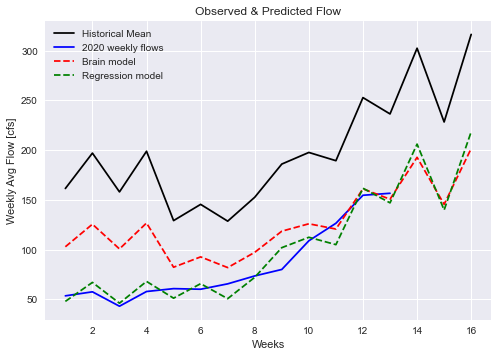

In [14]:
# Section 5: Graphs
# Section 5.1: a line plot
plt.style.use('seaborn')

fig, ax = plt.subplots()
ax.plot(mymodel['hist_data'].T, color='black', label='Historical Mean')
ax.plot(mymodel['data_2020'].T, color='blue', label='2020 weekly flows')
ax.plot(mymodel['forecasts16'].T, color='r', label='Brain model',
        linestyle="--")
ax.plot(mymodel['Rmodel'].T, color='green', label='Regression model',
        linestyle="--")
ax.set(title="Observed & Predicted Flow", xlabel="Weeks",
       ylabel="Weekly Avg Flow [cfs]")
ax.legend()

fig.savefig('plot_lines.png')

The Section 5.2 creates a scatter plot. Here, we can observe the dispersion of the 2020 observed and the historical flows from the week starting in 2020-08-23 to the most recent week. The dispersion increases for higher values.

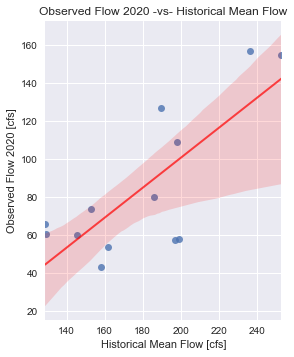

In [15]:
# Section 5.2: a scatter plot
plt.style.use('seaborn')

fig, ax = plt.subplots()
ax.set_aspect(1)
sns.regplot(x=mymodel.loc[1:current_week]['hist_data'].values,
            y=mymodel.loc[1:current_week]['data_2020'].values,
            line_kws={"color": "r", "alpha": 0.7, "lw": 2})
ax.set(title="Observed Flow 2020 -vs- Historical Mean Flow",
       ylabel="Observed Flow 2020 [cfs]",
       xlabel="Historical Mean Flow [cfs]")

fig.savefig("plot_scatter.png")